In [92]:
import numpy as np  
import pandas as pd
import os
import re
from random import shuffle

In [93]:
def text_cleaner(text):
    text = text.lower()
    text = re.sub(r"[.,\")(>+<*/]", " ", text)
    text = re.sub(r"[']", "", text)
    text = re.sub(r"[!]", " !", text)
    return re.sub(r"[?]", " ?", text)

def rate_cleaner(rate):
    if int(rate[rate.index('_') + 1 : rate.index('.')]) >= 6:
        return 1
    else: 
        return 0

def text_transformer(text, vocabulary):
    cleaned_text = text_cleaner(text).split()
    for word in range(len(cleaned_text)):
        cleaned_text[word] = vocabulary[cleaned_text[word]] if vocabulary.get(cleaned_text[word]) != None else 0
    return cleaned_text

def file_reader(dir_name, vocabulary):
    vector = []
    rate = []
    
    for name in os.listdir(dir_name):
        if name != '.ipynb_checkpoints':
            with open(os.path.join(dir_name, name), 'r') as file:
                rate.append(rate_cleaner(name))
                text = file.read()
                vector.append(text_transformer(text, vocabulary))
            
    return vector, rate

def pad_sequences(arr, maxlen):
    for i in range(len(arr)):
        if len(arr[i]) < maxlen: 
            arr[i] += [0 for x in range(maxlen - len(arr[i]))]
        elif len(arr[i]) > maxlen:
            arr[i] = arr[i][:maxlen] 
        arr[i] = np.array(arr[i])
    return arr

In [94]:
vocabulary = []
expected_rating = []

with open('imdb.vocab', 'r') as file_handler:
    vocabulary = file_handler.read().splitlines()
    
with open('imdbEr.txt', 'r') as file_handler:
    expected_rating = list(map(float, file_handler.read().splitlines()))
    
vocab_Er = dict(zip(vocabulary, expected_rating))

vector_neg_train, rate_neg_train = file_reader('neg_train', vocab_Er)
vector_pos_train, rate_pos_train = file_reader('pos_train', vocab_Er)
vector_neg_test, rate_neg_test = file_reader('neg_test', vocab_Er)
vector_pos_test, rate_pos_test = file_reader('pos_test', vocab_Er)

x_train, y_train = vector_neg_train + vector_pos_train, rate_neg_train + rate_pos_train
x_test, y_test = vector_neg_test + vector_pos_test, rate_neg_test + rate_pos_test

train = pd.DataFrame({'X': x_train, 'y' : y_train}).sample(frac=1)
test = pd.DataFrame({'X': x_test, 'y': y_test}).sample(frac=1)

x_train, y_train = np.array(train.X), np.array(train.y)
x_test, y_test = np.array(test.X), np.array(test.y)

In [95]:
x_train, y_train = np.array(train.X), np.array(train.y)
x_test, y_test = np.array(test.X), np.array(test.y)

avg_length = 375

x_train = pad_sequences(x_train, maxlen=avg_length)
x_test = pad_sequences(x_test, maxlen=avg_length)

x_train_t = []

for i in x_train:
    x_train_t.append(i)

x_train_t = np.array(x_train_t)

x_test_t = []

for i in x_test:
    x_test_t.append(i)
    
x_test_t = np.array(x_test_t)

In [96]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()

model.add(Dense(avg_length, activation = "relu", input_shape=(avg_length, )))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.1, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

model.compile( optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 375)               141000    
_________________________________________________________________
dense_20 (Dense)             (None, 50)                18800     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
__________

In [97]:
hist = model.fit(x_train_t, 
                 y_train, 
                 validation_data=(x_test_t, y_test), 
                 epochs=2, 
                 batch_size=100
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 4s 159us/step - loss: 0.4282 - acc: 0.8157 - val_loss: 0.4042 - val_acc: 0.8283
Epoch 2/2
25000/25000 [==============================] - 3s 138us/step - loss: 0.3652 - acc: 0.8493 - val_loss: 0.3949 - val_acc: 0.8306


[]

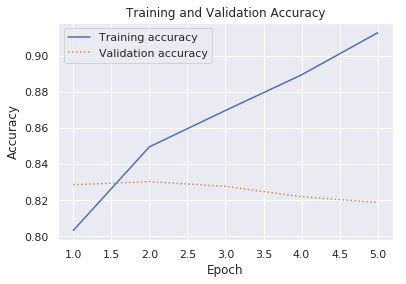

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['acc']
val = hist.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

* avg_len = 235 - the best = 0.8223
* avg_len = 300 - the best = 0.8267
* avg_len = 350 - the best = 0.8285
* avg_len = 375 - the best = 0.8302
* avg_len = 400 - the best = 0.8274

In [98]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [99]:
from keras.models import model_from_json

In [100]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

In [101]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_test_t, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 83.06%


In [24]:
def text_cleaner(text):
    text = text.lower()
    text = re.sub(r"[.,\")(>+<*/]", " ", text)
    text = re.sub(r"[']", "", text)
    text = re.sub(r"[!]", " !", text)
    return re.sub(r"[?]", " ?", text)

def text_transformer(text, vocabulary):
    cleaned_text = text_cleaner(text).split()
    for word in range(len(cleaned_text)):
        cleaned_text[word] = vocabulary[cleaned_text[word]] if vocabulary.get(cleaned_text[word]) != None else 0
    return cleaned_text


def load_model(filename_json, filename_weights):
    loaded_model_json = None

    with open(filename_json, 'r') as json_file:
        loaded_model_json = json_file.read()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(filename_weights)

    return loaded_model

def load_vocabulary_rate(vocab_words, vocab_rates):
    vocabulary = []
    expected_rating = []
    
    with open(vocab_words, 'r') as file_handler:
        vocabulary = file_handler.read().splitlines()

    with open(vocab_rates, 'r') as file_handler:
        expected_rating = list(map(float, file_handler.read().splitlines()))

    return dict(zip(vocabulary, expected_rating))

def load_vocabulary_numbs(vocab_words):
    vocabulary_numbs = {}
    number = 1
    
    with open(vocab_words, 'r') as file_handler:
        for word in file_handler:
            vocabulary_numbs[word.strip()] = number
            number += 1

    return vocabulary_numbs

def text_fitter(length, text):
    if len(text) < length:
        return np.array(list(text) + [0 for x in range(length-len(text))])
    else:
        return np.array(list(text)[:length])

def file_reader(dir_name, vocabulary, length):
    vector = []
    rate = []
    
    for name in os.listdir(dir_name):
        if name != '.ipynb_checkpoints':
            with open(os.path.join(dir_name, name), 'r') as file:
                rate.append(rate_cleaner(name))
                text = file.read()
                vector.append(text_fitter(length, text_transformer(text, vocabulary)))
            
    return vector, rate


In [21]:
model_l = load_model('model_ltsm.json', 'model_ltsm.h5')
model_s = load_model('model_sem.json', 'model_sem.h5')

In [79]:
x_test_v_300, y_test_v_300 = file_reader('pos_test', load_vocabulary_numbs('imdb.vocab'), 300) 

In [80]:
x_test_v_375, y_test_v_375 = file_reader('pos_test', load_vocabulary_rate('imdb.vocab', 'imdbEr.txt'), 375) 

In [81]:
rates = []
true = 0
for i in range(len(x_test_v_300)):
    model_l_prediction = model_l.predict(x_test_v_300[i].reshape(1, 300))[0][0]
    model_s_prediction = model_s.predict(x_test_v_375[i].reshape(1, 375))[0][0]
    
    
    rates.append(int(str(round((model_l_prediction+model_l_prediction)/2, 2))[2]))

In [82]:
true = 0

In [83]:
for i in rates:
    if i >= 5:
        true += 1

In [86]:
print(f"Accuracy: {round(true/12500, 2) * 100}%")

Accuracy: 87.7%
